<a href="https://colab.research.google.com/github/jobellet/vlPFC_Visual_Geometry/blob/main/RSA_with_DNNs_processing_original_or_blurry_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# RSA with DNNs processing original or blurry images
-----------------------------------------------------------------------------
This script generates the figure comparing vlPFC representational geometry in the early and late time periods with DNN representations of the original images or the images that are blurred to simulate the information available from the magnocellular pathway
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# Run analysis

downloads/hvm_public_extended_meta.csv already exists.
downloads/deepNetFeatures.zip already exists.
downloads/Spike_count_even_sessions.npy already exists.
downloads/Spike_count_odd_sessions.npy already exists.


/tmp/ipython-input-2165740673.py:125: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  feat[m["net"]][m["flav"]] = pickle.load(fh)
/tmp/ipython-input-2165740673.py:215: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xi, yi, s=24, marker=MARKERS[k], c=col, alpha=.6, edgecolors='none')
/tmp/ipython-input-2165740673.py:215: UserWarning: You passed a edgecolor/ed

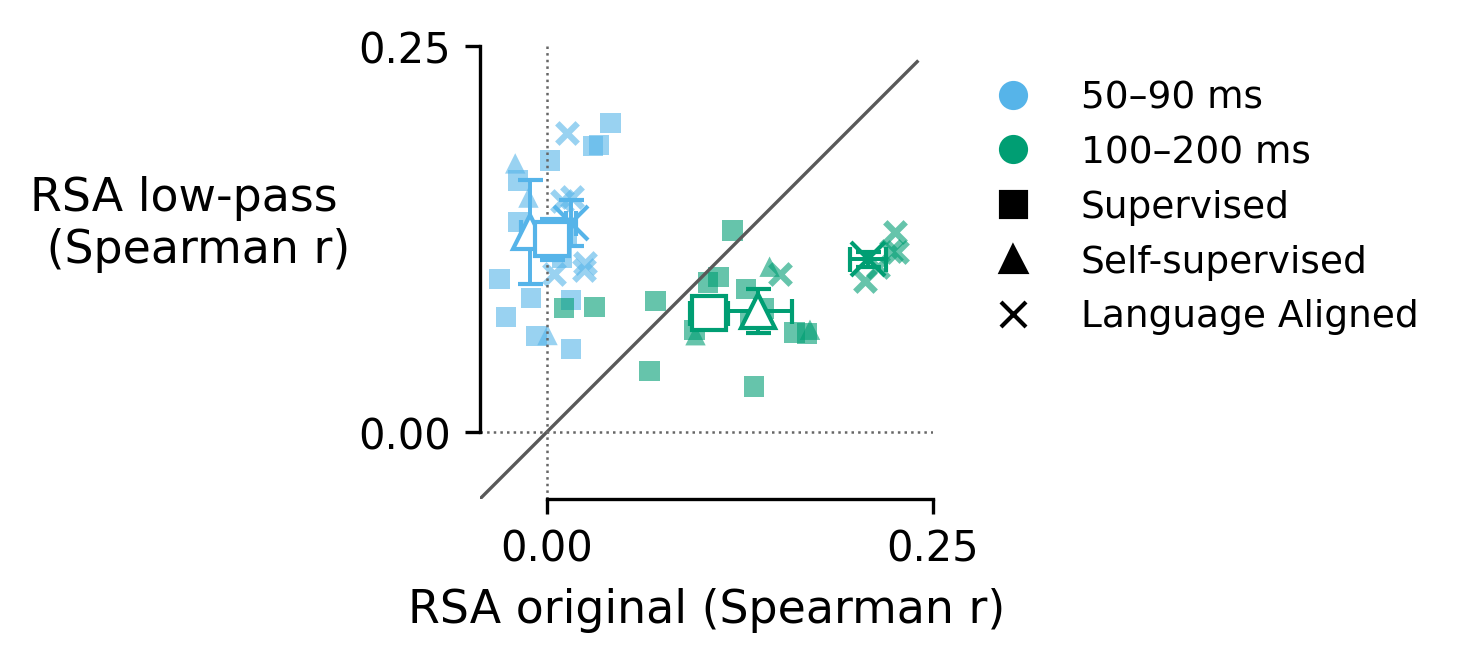

,Window,Condition,Mean,SEM,Direction,p,q,Sig
0,50–90 ms,Original,0.005,0.004,,0.1219,0.1219,
1,50–90 ms,Low-pass,0.128,0.010,,0.0001,0.0001,***
2,50–90 ms,Orig – LP,-0.123,NaN,LP > Orig,0.0001,0.0001,***
3,100–200 ms,Original,0.136,0.012,,0.0001,0.0001,***
4,100–200 ms,Low-pass,0.087,0.006,,0.0001,0.0001,***
5,100–200 ms,Orig – LP,0.050,NaN,Orig > LP,0.0004,0.0005,***


,Window,GroupA,GroupB,Direction,p,q,Sig
0,50–90 ms,Language Aligned,Supervised,Language Aligned > Supervised,0.4256,0.5107,
1,50–90 ms,Language Aligned,Self-supervised,Language Aligned > Self-supervised,0.2888,0.5107,
2,50–90 ms,Self-supervised,Supervised,Supervised > Self-supervised,0.8368,0.8368,
3,100–200 ms,Language Aligned,Supervised,Language Aligned > Supervised,0.0001,0.0006,***
4,100–200 ms,Language Aligned,Self-supervised,Language Aligned > Self-supervised,0.0120,0.0360,*
5,100–200 ms,Self-supervised,Supervised,Self-supervised > Supervised,0.3429,0.5107,


▶ Checking / downloading stimulus images …
Successfully downloaded downloads/high_variation_stimuli.zip.
▶ Creating low‑pass stimulus set (magnocellular filter) …


100%|██████████| 2560/2560 [00:30<00:00, 84.36it/s]


▶ Checking / downloading DNN feature pickles …
  → Using 6 CLIP nets: CLIP_RN50, CLIP_ViT-B_32, OpenCLIP_RN101_openai, OpenCLIP_RN50_openai, OpenCLIP_ViT-B_32_laion2b, OpenCLIP_ViT-B_32_openai
▶ Batch: 4a45c4fa9dbbf50babc8c6f269c871dcf2b32b3d, 724190b00db37fe4bbcacb5c3defd2dd0406c0dd, 647033dde44dc5e6cb8a2769702c3bf4e3ad62fb, 0774075705cd11f7f9a116ce27013b1c25c18933, 61fb699963224ce272db234726f08a9d35e95405, 4c7a4d0924d54d2fa04cebe79f50b13ef337a49e, f4603b58318b9e573e3b2c00b8371b482db89cf5, f22d80284c4f74007815cf58ea54d708b98fe16a, ec333a99d07fb44e6c281b62826ffea0db0d86bb, f21151cbd2867408892bcdfa3a30f814088268da, 380298e08baec53951e558dbec3e43d93fc3c844, 3a6b55ee2008f8e28f77ef447afa3d1b72229b88, a7921edee8c274410bfe85f7719bb95ec417442c, 5179cfba2262ebbc8453b63a4d68cf0c564ebb69, 0472d0e888d521497b6bdf3b57c20c216c293912, d9ea54c5ae94da39d8f3759d2033a8826160febb
▶ Running metric‑MDS …


/tmp/ipython-input-2165740673.py:418: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return [Path(p).stem for p in pickle.load(fh)["image_names"]]
/tmp/ipython-input-2165740673.py:439: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the pu

▶ Rendering & saving figures …


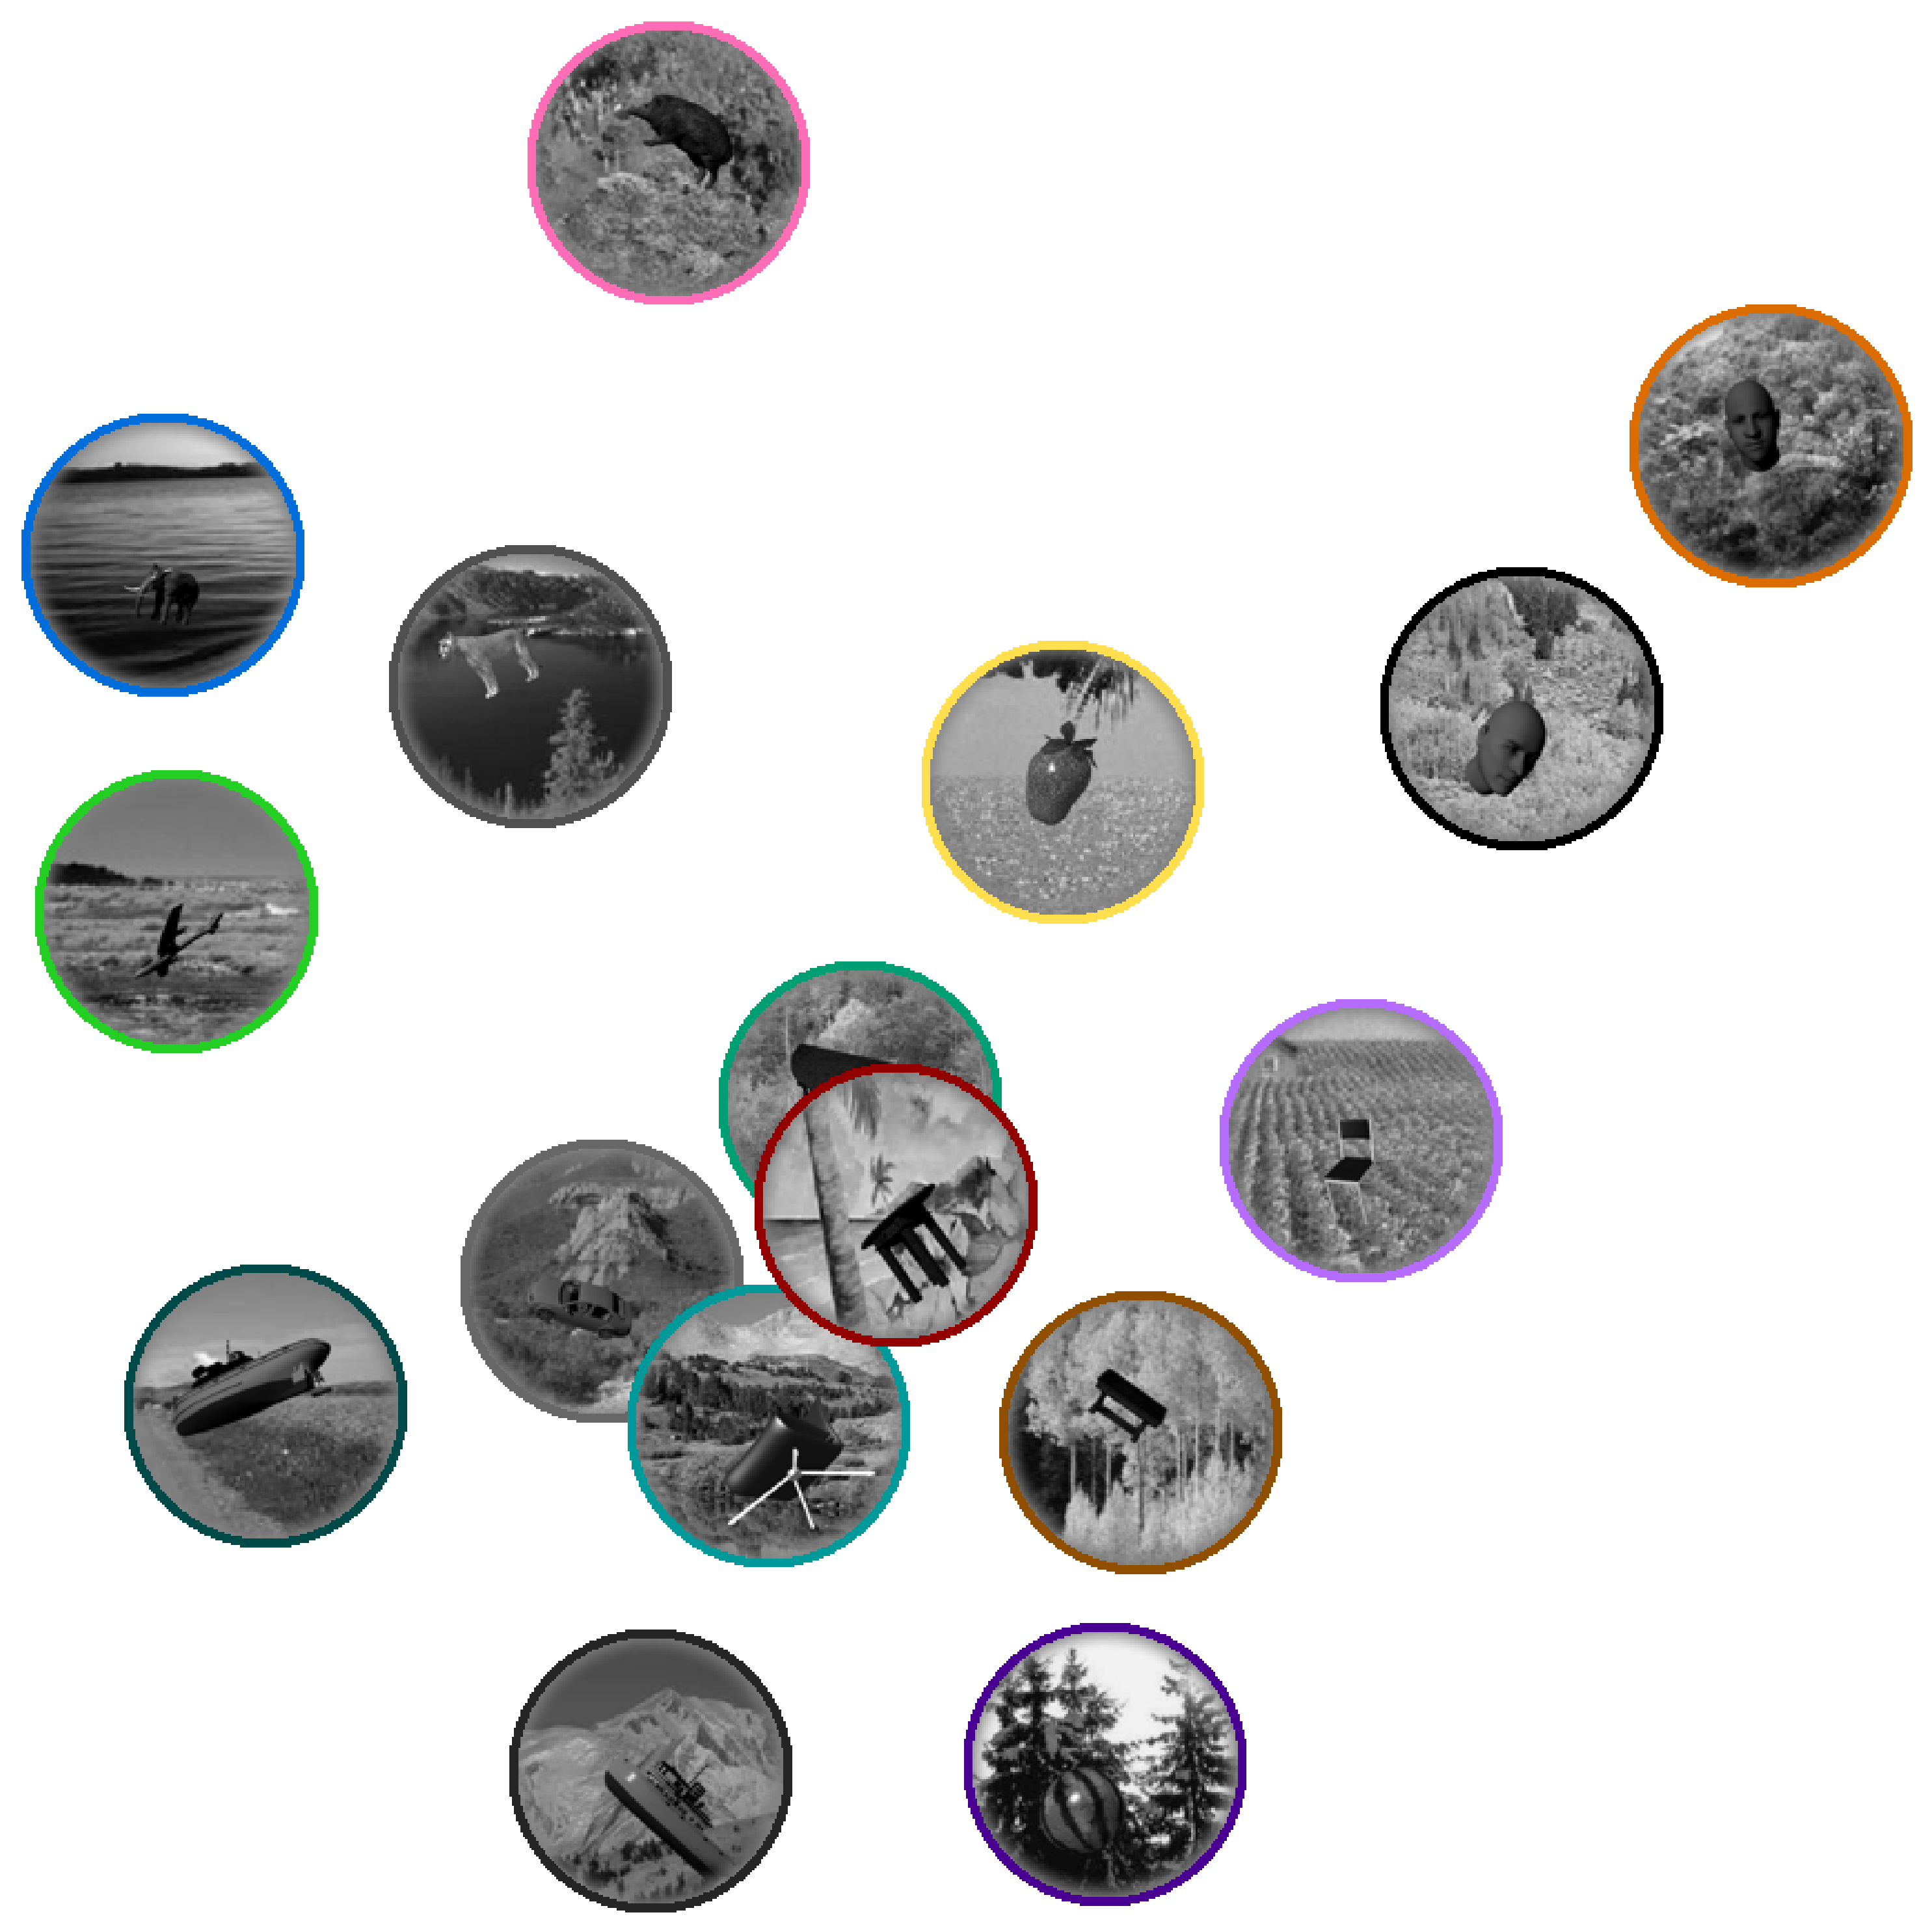

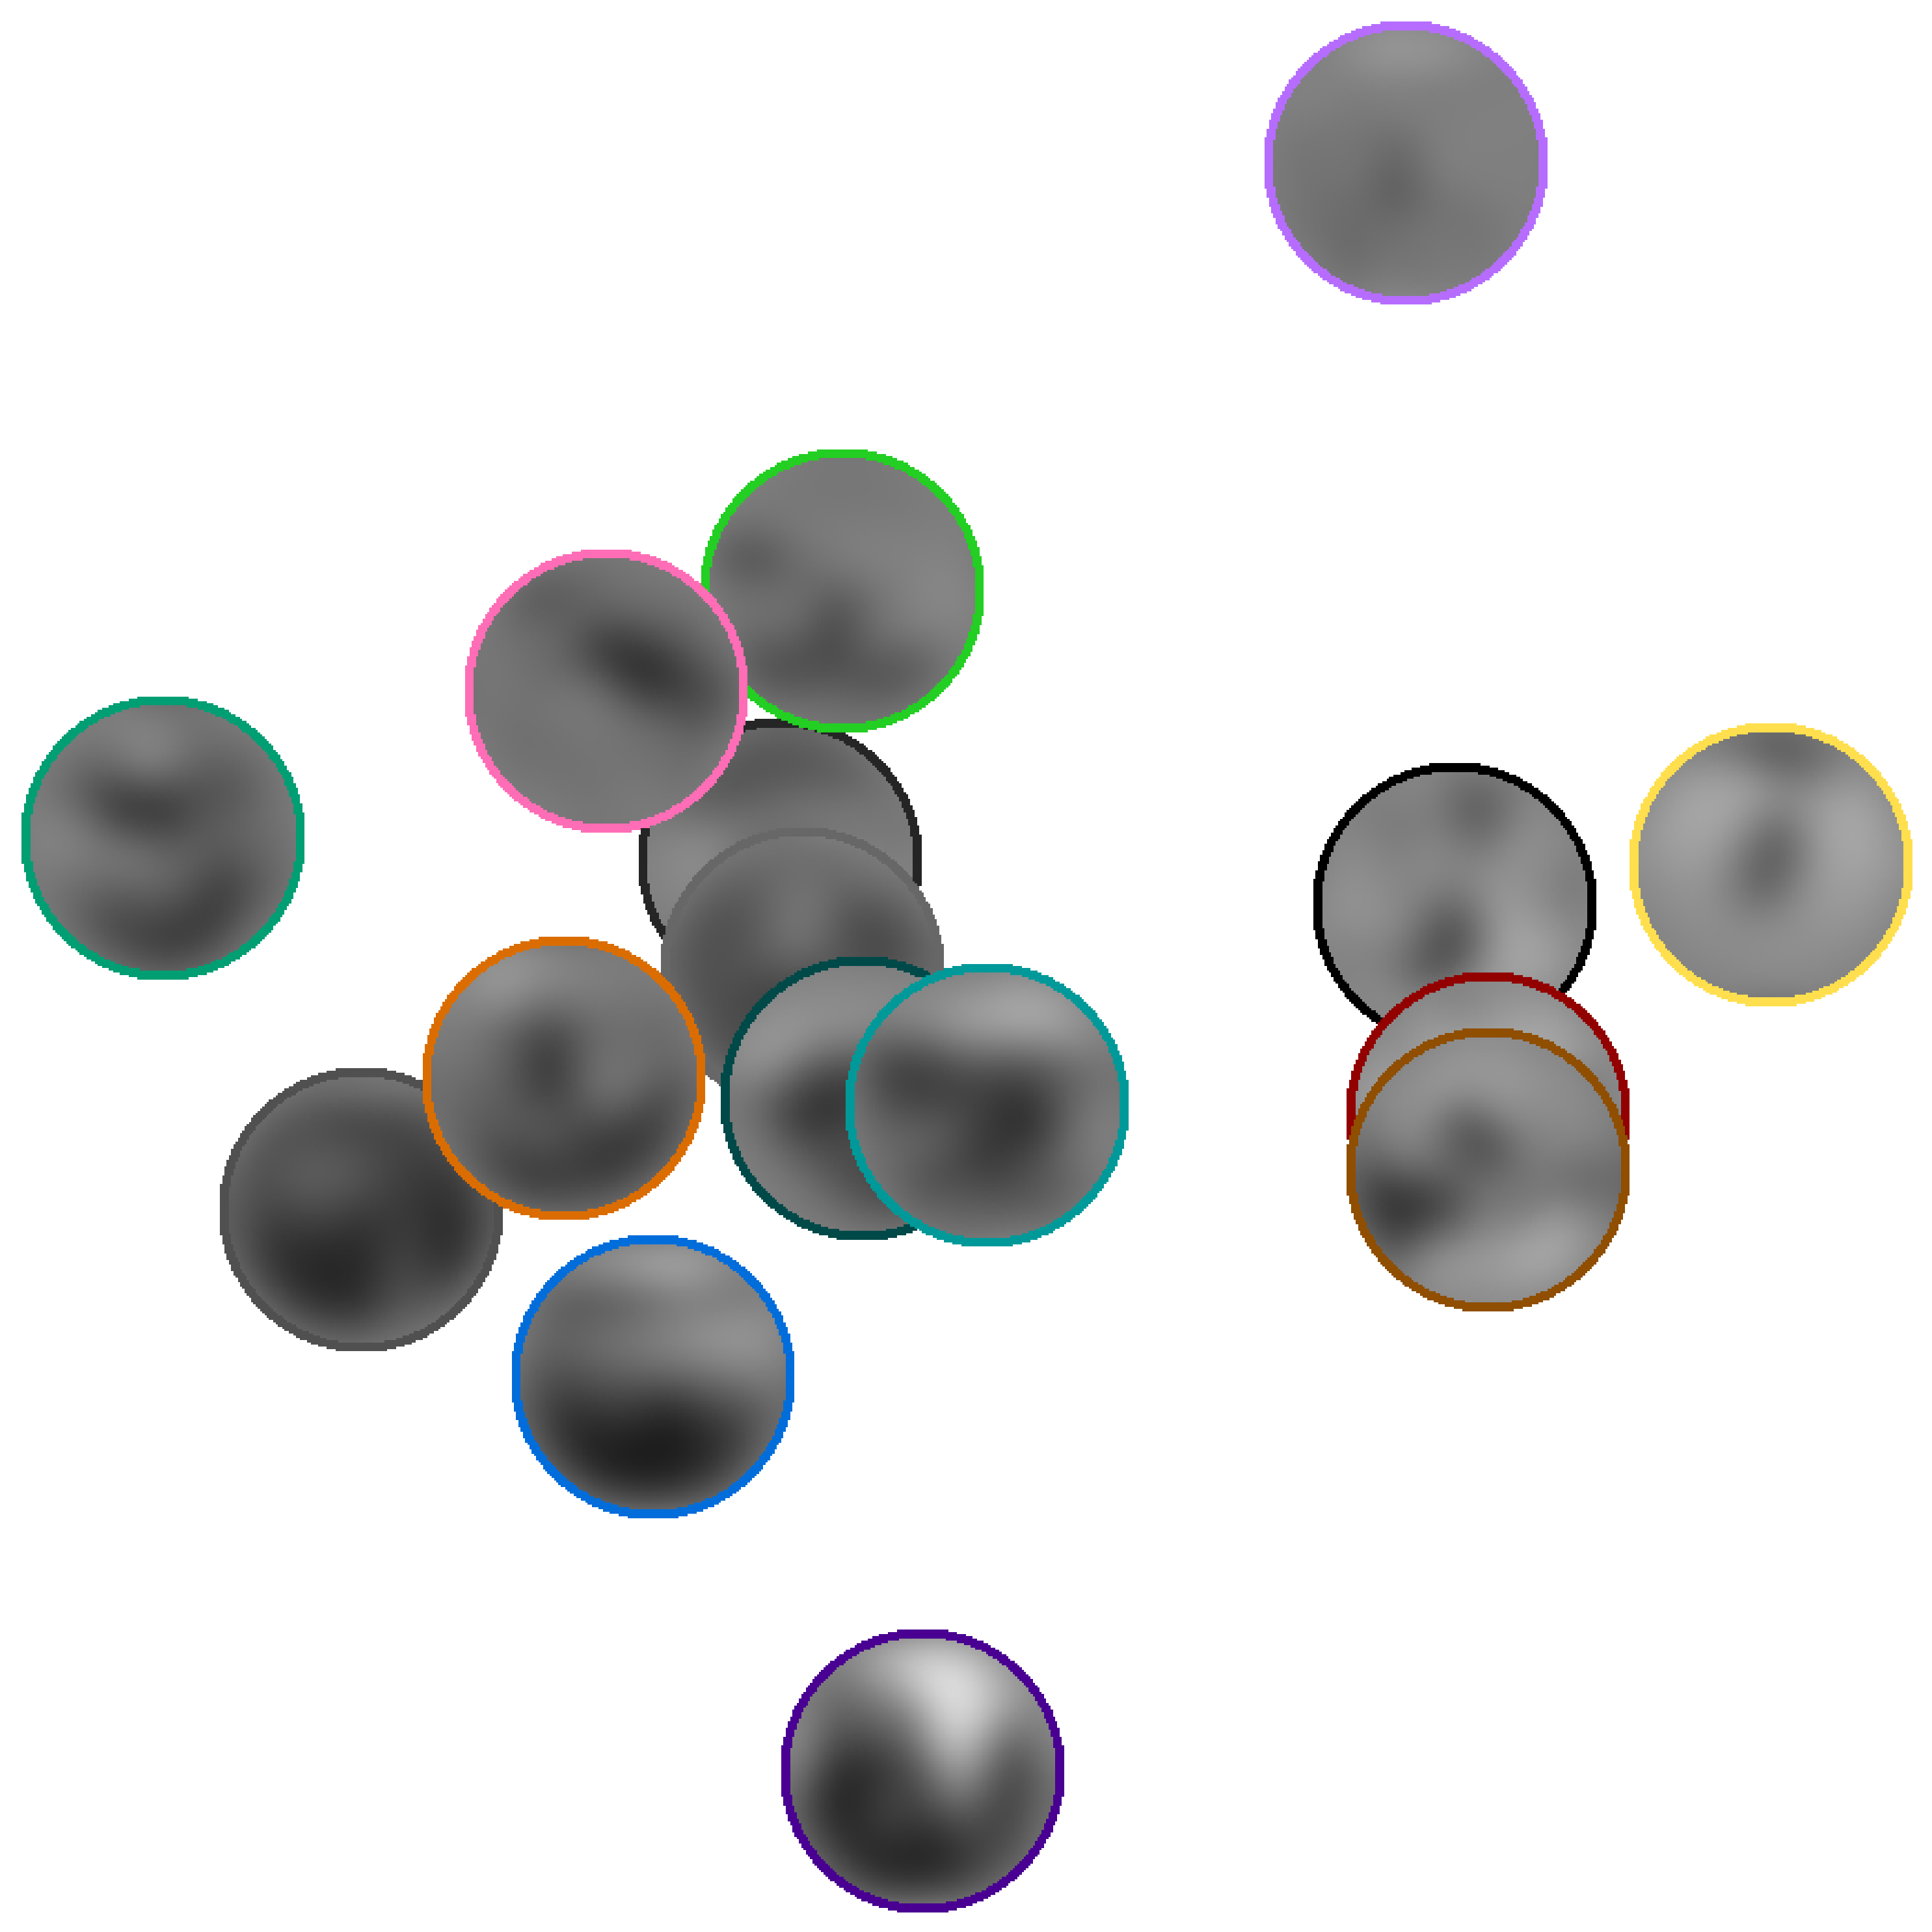

✓ Done – figures saved in the ‘Figures’ directory.


In [4]:
""" RSA with DNNs processing original or blurry images
This script generates the figure comparing vlPFC representational geometry
in the early and late time periods with DNN representations of the original
images or the images that are blurred to simulate the information available
from the magnocellular pathway
"""

import warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from PIL import Image
import cv2
import time
import re
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True


# Determine the path to the repository based on the environment
if IN_COLAB:
    path_to_repo = '/content/vlPFC_Visual_Geometry'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/vlPFC_Visual_Geometry'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'


# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/vlPFC_Visual_Geometry.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils')) # Add the utils directory to sys.path


from utils.extract_and_download_data import download_files, unzip

from utils.analysis_utils import (get_upper_indices, pairwise_euclidean_distance,
                                  spearman_corr_ranked, training_kind, round_robin_pairs,
                                  pairs_to_batches, perm_signflip_onesample, perm_diff_independent, condensed)
from utils.plotting_utils import q_to_stars

jax.config.update("jax_enable_x64", True)
warnings.filterwarnings("ignore", category=FutureWarning)
rng_global = np.random.default_rng(42)

BATCH_SIZE  = 16
TIME_WINDOWS = {                       # indices on the >0 ms axis
    "50–90 ms":   slice(5,  9),        # 50–90 ms
    "100–200 ms": slice(10, 20)        # 105–195 ms
}
PALETTE = {                            # Okabe–Ito, red-green safe
    "50–90 ms":   "#56B4E9",
    "100–200 ms": "#009E73"
}
MARKERS = {"Supervised": "s", "Self-supervised": "^", "Language Aligned": "x"}
N_PERM  = 10_000

FIGURES_DIR = Path("Figures")
STATISTICS_DIR = Path("Statistics")

plt.rcParams.update({
    "figure.dpi":         300,
    "axes.spines.top":    False,
    "axes.spines.right":  False,
    "axes.labelsize":     11,
    "xtick.labelsize":    10,
    "ytick.labelsize":    10,
})
FIGURES_DIR.mkdir(exist_ok=True)
STATISTICS_DIR.mkdir(exist_ok=True) # Create the Statistics directory


# ──────────────────────────────────────────────────────────────────────
#  3.  Data download (first run only)
# ──────────────────────────────────────────────────────────────────────
download_files(path_to_repo, ["deepNetFeatures.zip", "Spike_count_even_sessions.npy", "Spike_count_odd_sessions.npy", "hvm_public_extended_meta.csv"], private_link=private_link)
unzip(Path("downloads") / "deepNetFeatures.zip", "deepNetFeatures")

meta           = pd.read_csv(Path("downloads") / "hvm_public_extended_meta.csv")
spike_counts_even, spike_counts_odd      = np.load(Path("downloads") / "Spike_count_even_sessions.npy"), np.load(Path("downloads") / "Spike_count_odd_sessions.npy")

spike_counts  = .5 * (spike_counts_even+spike_counts_odd)
n_stim = spike_counts.shape[0]
stim_base = meta['image_id'].str.strip().tolist()

def slice_flat(arr, slc):
    return arr[:, :, slc].reshape(n_stim, -1)

neural = {lbl: slice_flat(spike_counts, sli) for lbl, sli in TIME_WINDOWS.items()}

# ──────────────────────────────────────────────────────────────────────
#  5.  Load DNN features
# ──────────────────────────────────────────────────────────────────────
feat_dir, patt = Path("deepNetFeatures"), re.compile(r"^(?P<net>.*)_features_high_variation_(?P<flav>original|lowpass)\.pkl$")
feat = defaultdict(dict)
for pkl in feat_dir.glob("*.pkl"):
    if (m := patt.match(pkl.name)):
        with open(pkl, "rb") as fh:
            feat[m["net"]][m["flav"]] = pickle.load(fh)

feat  = {k: v for k, v in feat.items() if set(v) == {"original", "lowpass"}}
nets  = sorted(feat)
train_type = {n: training_kind(n) for n in nets}

# ──────────────────────────────────────────────────────────────────────
#  6.  RSA computation (pair-unique 16-stim batches)
# ──────────────────────────────────────────────────────────────────────
rsa = {lbl: {} for lbl in TIME_WINDOWS}
for net in nets:
    f_o, f_l = feat[net]["original"]["penultimate"], feat[net]["lowpass"]["penultimate"]
    if f_o.ndim > 2: f_o = f_o.reshape(f_o.shape[0], -1)
    if f_l.ndim > 2: f_l = f_l.reshape(f_l.shape[0], -1)

    names_o = [Path(x).stem for x in feat[net]["original"]["image_names"]]
    names_l = [Path(x).stem for x in feat[net]["lowpass"]["image_names"]]
    common  = sorted(set(names_o) & set(names_l) & set(stim_base))
    if len(common) < BATCH_SIZE:
        warnings.warn(f"{net}: skipped (only {len(common)} common stimuli)"); continue

    idx_o = np.array([names_o.index(s)   for s in common])
    idx_l = np.array([names_l.index(s)   for s in common])
    idx_n = np.array([stim_base.index(s) for s in common])

    rr, batches = round_robin_pairs(len(common), rng_global), []
    for rnd in rr: batches.extend(pairs_to_batches(rnd, BATCH_SIZE))
    batches = batches[:len(common) // BATCH_SIZE]

    accum = {lbl: {"o": [], "l": []} for lbl in TIME_WINDOWS}
    for b in batches:
        # The 'condensed' function is now in utils/analysis_utils.py
        # and imported at the top of this file.
        r_o, r_l = rankdata(condensed(f_o[idx_o[b]])), rankdata(condensed(f_l[idx_l[b]]))
        for lbl, neu_mat in neural.items():
            r_n = rankdata(condensed(neu_mat[idx_n[b]]))
            accum[lbl]["o"].append(spearman_corr_ranked(r_n, r_o))
            accum[lbl]["l"].append(spearman_corr_ranked(r_n, r_l))

    for lbl in TIME_WINDOWS:
        for k in ("o", "l"):
            vec, mu, sem = np.asarray(accum[lbl][k]), None, None
            mu = float(vec.mean()); sem = float(vec.std(ddof=1) / np.sqrt(len(vec)))
            accum[lbl][k] = (mu, sem)
        rsa[lbl][net] = (*accum[lbl]["o"], *accum[lbl]["l"])


# ──────────────────────────────────────────────────────────────────────
#  7.  Gather vectors per window & stats
# ──────────────────────────────────────────────────────────────────────
vals, one_p, pair_p = {}, {}, {}
for lbl in TIME_WINDOWS:
    mu_o = np.array([rsa[lbl][n][0] for n in nets if n in rsa[lbl]])
    se_o = np.array([rsa[lbl][n][1] for n in nets if n in rsa[lbl]])
    mu_l = np.array([rsa[lbl][n][2] for n in nets if n in rsa[lbl]])
    se_l = np.array([rsa[lbl][n][3] for n in nets if n in rsa[lbl]])
    kept = [n for n in nets if n in rsa[lbl]]
    vals[lbl] = (mu_o, se_o, mu_l, se_l, kept)

    # one-sample (Orig, LP) and paired (Orig vs LP) – same as before
    _, _, p_o = perm_signflip_onesample(mu_o, N_PERM, greater=True)
    _, _, p_l = perm_signflip_onesample(mu_l, N_PERM, greater=True)
    one_p[lbl] = (p_o, p_l)

    _, _, p_pair = perm_diff_independent(mu_o, mu_l, N_PERM, two_sided=True)
    pair_p[lbl] = p_pair

# FDR across all the above p’s
raw_p = [*sum(one_p.values(), ()), *pair_p.values()]
_, q_all, *_ = multipletests(raw_p, method="fdr_bh")
q_iter, q_one, q_pair = iter(q_all), {}, {}
for lbl in TIME_WINDOWS:        # Orig, LP
    q_one[lbl] = (next(q_iter), next(q_iter))
for lbl in TIME_WINDOWS:        # paired
    q_pair[lbl] = next(q_iter)

# ──────────────────────────────────────────────────────────────────────
#  8.  Scatter plot
# ──────────────────────────────────────────────────────────────────────
def group_stats(values, types):
    df = pd.DataFrame({'val': values, 'kind': types})
    return df.groupby('kind')['val'].mean(), df.groupby('kind')['val'].sem(ddof=1)

fig, ax = plt.subplots(figsize=(5, 5)); ax.set_aspect('equal')

for lbl, (xo, _, xl, _, kept) in vals.items():
    col, kinds = PALETTE[lbl], [training_kind(n) for n in kept]

    # 1 individual nets
    for xi, yi, k in zip(xo, xl, kinds):
        ax.scatter(xi, yi, s=24, marker=MARKERS[k], c=col, alpha=.6, edgecolors='none')

    # 2 group means ± SEM
    μx, σx = group_stats(xo, kinds); μy, σy = group_stats(xl, kinds)
    for k in μx.index:
        ax.errorbar(μx[k], μy[k], xerr=σx[k], yerr=σy[k],
                    fmt=MARKERS[k], mfc='white', mec=col,
                    ecolor=col, elinewidth=.95, capsize=3, zorder=4, ms=8)

lims = np.array([ax.get_xlim(), ax.get_ylim()]).flatten(); lims = lims.min(), lims.max()
ax.plot(lims, lims, lw=.8, c='0.35'); ax.set_xlim(lims); ax.set_ylim(lims)
ax.axhline(0, lw=.6, c='0.4', ls=':'); ax.axvline(0, lw=.6, c='0.4', ls=':')
ax.set_xlabel("RSA original (Spearman r)"); ax.set_ylabel("RSA low-pass \n (Spearman r)", rotation = 0, labelpad=40)

handles = ([plt.Line2D([0], [0], marker='o', ls='', c=PALETTE[lbl]) for lbl in TIME_WINDOWS] +
           [plt.Line2D([0], [0], marker=MARKERS[k], ls='', c='k')     for k in MARKERS])
labels  = list(TIME_WINDOWS.keys()) + list(MARKERS.keys())
ax.legend(handles, labels, fontsize=9, frameon=False,
          title="", title_fontsize=9,
          loc='upper left', bbox_to_anchor=(1.02, 1))

ax.set_xticks([0,.25]); ax.set_yticks([0,.25])
sns.despine(ax=ax,trim=True)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.pdf", bbox_inches="tight")
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.jpeg", dpi=300, bbox_inches="tight")
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.svg", bbox_inches="tight")
if IN_COLAB or IN_KAGGLE:
    plt.show()
else:
    plt.close(fig)

# ──────────────────────────────────────────────────────────────────────
#  9.  Statistics tables
# ──────────────────────────────────────────────────────────────────────
from IPython.display import display

def direction_tt(mu_a, mu_b, grp_a, grp_b):
    if np.isclose(mu_a, mu_b): return "≈"
    return f"{grp_a} > {grp_b}" if mu_a > mu_b else f"{grp_b} > {grp_a}"

# 9 a) one-sample & image-condition paired tests
rows = []
for lbl in TIME_WINDOWS:
    mu_o, _, mu_l, _, _ = vals[lbl]
    diff                = mu_o.mean() - mu_l.mean()

    p_o, p_l            = one_p[lbl]
    q_o, q_l            = q_one[lbl]
    p_pair, q_pair_w    = pair_p[lbl], q_pair[lbl]

    rows += [
        dict(Window=lbl, Condition="Original",  Mean=mu_o.mean(),
             SEM=mu_o.std(ddof=1)/np.sqrt(len(mu_o)),
             Direction="", p=p_o, q=q_o, Sig=q_to_stars(q_o)),
        dict(Window=lbl, Condition="Low-pass",  Mean=mu_l.mean(),
             SEM=mu_l.std(ddof=1)/np.sqrt(len(mu_l)),
             Direction="", p=p_l, q=q_l, Sig=q_to_stars(q_l)),
        dict(Window=lbl, Condition="Orig – LP", Mean=diff, SEM=np.nan,
             Direction=("Orig > LP" if diff > 0 else "LP > Orig"),
             p=p_pair, q=q_pair_w, Sig=q_to_stars(q_pair_w)) # Fixed stars function call
    ]

stats_df = (pd.DataFrame(rows)
              .loc[:, ["Window","Condition","Mean","SEM",
                       "Direction","p","q","Sig"]]
              .round({"Mean":3, "SEM":3, "p":4, "q":4}))
stats_df.to_csv(STATISTICS_DIR / "RSA_summary_stats.csv", index=False)

# 9 b) training-type comparisons on (RSA_orig + RSA_lp)/2
pair_rows = []
for lbl in TIME_WINDOWS:
    kept   = vals[lbl][4]
    kinds  = pd.Series({n: training_kind(n) for n in kept})
    mu_o   = pd.Series(vals[lbl][0], index=kept)
    mu_l   = pd.Series(vals[lbl][2], index=kept)
    mu_avg = .5 * (mu_o + mu_l)                 # ← overall RSA

    for a in kinds.unique():
        for b in kinds.unique():
            if a >= b:                          # unordered pairs once
                continue
            xa, xb = mu_avg[kinds==a], mu_avg[kinds==b]
            _, _, p = perm_diff_independent(xa, xb, N_PERM)
            pair_rows.append(dict(Window    = lbl,
                                   GroupA    = a,
                                   GroupB    = b,
                                   Direction = direction_tt(xa.mean(), xb.mean(), a, b),
                                   p         = p))

# FDR across *all* these p’s
pairwise_df = pd.DataFrame(pair_rows)
_, q_vals, *_       = multipletests(pairwise_df["p"], method="fdr_bh")
pairwise_df["q"]    = q_vals
pairwise_df["Sig"]  = [q_to_stars(q) for q in q_vals] # Fixed stars function call

pairwise_df = (pairwise_df
                 .round({"p":4, "q":4})
                 .loc[:, ["Window","GroupA","GroupB","Direction","p","q","Sig"]])
pairwise_df.to_csv(STATISTICS_DIR / "RSA_pairwise_trainingtype.csv", index=False)

# ── show in interactive sessions
display(stats_df)
display(pairwise_df)

"""# Display MDS of original and low passed representational geometries of a DNN of a batch of images"""

#!/usr/bin/env python
"""
Script 2 — CLIP‑average RDM → MDS visualisation
------------------------------------------------
For a *single* 16‑image batch we:
1. Load all CLIP‑based networks’ penultimate‑layer feature tensors (pre‑computed
   in `deepNetFeatures/*_features_high_variation_{original|lowpass}.pkl`).
2. Compute the pairwise‑Euclidean representational‑dissimilarity matrix (RDM)
   for *each* network and flavour (original vs. low‑pass).
3. Average those RDMs across networks → one mean RDM per flavour.
4. Run metric‑MDS (2‑D) on each averaged RDM.
5. Render the two layouts with `plot_many_images_in_one_canevas`, saving to
   *Figures/MDS_CLIP_batch_original.png* and *Figures/MDS_CLIP_batch_lowpass.png*.

The batch is chosen reproducibly with `numpy.random.default_rng(42)`.
"""

# ──────────────────────────────────────────────────────────────────────
# 0. Imports & housekeeping
# ──────────────────────────────────────────────────────────────────────
from utils.extract_and_download_data import download_figshare_file, unzip, download_files
from utils.image_processing import m_pathway_filter_gaussian

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams.update({
    "figure.dpi":         300,
    "axes.spines.top":    False,
    "axes.spines.right":  False,
})

# ──────────────────────────────────────────────────────────────────────
# 1. Constants & directories
# ──────────────────────────────────────────────────────────────────────

FIGURES_DIR = Path("Figures")
STATISTICS_DIR = Path("Statistics")

FIG_DIR      = FIGURES_DIR
STIM_DIR     = Path("high_variation_stimuli")
LP_DIR       = Path("high_variation_stimuli_lowpass")
FEAT_DIR     = Path("deepNetFeatures")

# ──────────────────────────────────────────────────────────────────────
# 2. Ensure stimulus sets are present
# ──────────────────────────────────────────────────────────────────────

print("▶ Checking / downloading stimulus images …")
download_files(path_to_repo, ["high_variation_stimuli.zip"], private_link=private_link)
unzip(Path("downloads") / "high_variation_stimuli.zip", "")

# build low‑pass set only if directory is still empty
LP_DIR.mkdir(exist_ok=True)
if not any(LP_DIR.iterdir()):
    print("▶ Creating low‑pass stimulus set (magnocellular filter) …")
    img_files = sorted(STIM_DIR.glob("*.png"))
    for img_path in tqdm(img_files):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        lp  = m_pathway_filter_gaussian(img)
        # OpenCV expects 8‑ or 32‑bit depths for colour conversion → cast
        if lp.dtype != np.uint8:
            lp = np.clip(lp, 0, 255).astype(np.uint8)
        lp_rgb = cv2.cvtColor(lp, cv2.COLOR_GRAY2RGB)
        cv2.imwrite(str(LP_DIR / img_path.name), lp_rgb)

# ──────────────────────────────────────────────────────────────────────
# 3. Ensure CLIP feature pickles are present
# ──────────────────────────────────────────────────────────────────────

print("▶ Checking / downloading DNN feature pickles …")
unzip(Path("downloads") / "deepNetFeatures.zip", "deepNetFeatures")

# gather *all* nets that have both flavours; keep only CLIP/Language‑aligned
feat_paths = {}
patt = re.compile(r"^(?P<net>.*)_features_high_variation_(?P<flav>original|lowpass)\.pkl$", re.I)
for pkl in FEAT_DIR.glob("*.pkl"):
    if m := patt.match(pkl.name):
        net, flav = m["net"], m["flav"]
        feat_paths.setdefault(net, {})[flav] = pkl



clip_nets = sorted([n for n, d in feat_paths.items()
                    if set(d) == {"original", "lowpass"} and training_kind(n) == "Language Aligned"])  # noqa
if not clip_nets:
    raise RuntimeError("No CLIP (Language‑aligned) networks with both flavours found in deepNetFeatures.\n"
                       "Please verify that the ZIP extracted correctly and contains the expected pickles.")
print(f"  → Using {len(clip_nets)} CLIP nets: {', '.join(clip_nets)}")

# ──────────────────────────────────────────────────────────────────────
# 4. Determine common stimulus pool & choose batch
# ──────────────────────────────────────────────────────────────────────

def _load_names(pkl_path):
    with open(pkl_path, "rb") as fh:
        return [Path(p).stem for p in pickle.load(fh)["image_names"]]

names_all = [set(_load_names(feat_paths[n]["original"])) &
             set(_load_names(feat_paths[n]["lowpass"])) for n in clip_nets]
common = sorted(set.intersection(*names_all))
if len(common) < BATCH_SIZE:
    raise RuntimeError("Shared stimulus count is smaller than batch size.")

batch_idx   = rng_global.choice(len(common), size=BATCH_SIZE, replace=False)
batch_names = [common[i] for i in batch_idx]
print("▶ Batch:", ", ".join(batch_names))

_flatten = lambda a: a.reshape(a.shape[0], -1) if a.ndim > 2 else a

# ──────────────────────────────────────────────────────────────────────
# 5. Build mean RDMs (original & low‑pass)
# ──────────────────────────────────────────────────────────────────────
from scipy.stats import rankdata
rdm_o_all, rdm_l_all = [], []
for net in clip_nets:
    with open(feat_paths[net]["original"], "rb") as fh:
        f_o = _flatten(pickle.load(fh)["penultimate"])
    with open(feat_paths[net]["lowpass"], "rb") as fh:
        f_l = _flatten(pickle.load(fh)["penultimate"])

    names_net = _load_names(feat_paths[net]["original"])
    idx       = np.array([names_net.index(b) for b in batch_names])

    rdm_o_all.append(rankdata(pdist(f_o[idx], metric="euclidean")))
    rdm_l_all.append(rankdata(pdist(f_l[idx], metric="euclidean")))

mean_rdm_o = np.mean(rdm_o_all, axis=0)
mean_rdm_l = np.mean(rdm_l_all, axis=0)

# ──────────────────────────────────────────────────────────────────────
# 6. Metric‑MDS (2‑D)
# ──────────────────────────────────────────────────────────────────────

print("▶ Running metric‑MDS …")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords_o = mds.fit_transform(squareform(mean_rdm_o))
coords_l = mds.fit_transform(squareform(mean_rdm_l))

# ──────────────────────────────────────────────────────────────────────
# 7. Plot helper (with circular alpha mask)
# ──────────────────────────────────────────────────────────────────────


def plot_many_images_in_one_canevas(coordinates, impaths):
    """Draw 128×128 thumbnails with a 4-px colour-blind-safe ring (r = 60–64 px)."""
    # ── deterministic colour-blind-safe palette (16 colours) ──────────────
    palette_hex = [
        "#000000", "#252525", "#676767", "#009E73",
        "#505050", "#004949", "#009999", "#22CF22",
        "#490092", "#006DDB", "#B66DFF", "#FF6DB6",
        "#920000", "#8F4E00", "#DB6D00", "#FFDF4D",
    ]
    colors = np.array([mcolors.to_rgb(h) for h in palette_hex], float)

    # ── coordinate normalisation (as in your original) ────────────────────
    image_res   = 850
    coords_norm = (image_res - 128) * (coordinates - coordinates.min(0)) \
                  / (coordinates.max(0) - coordinates.min(0))

    fig, ax = plt.subplots(figsize=(10, 10)); ax.axis("off")
    canvas  = np.ones((image_res, image_res, 3), float)

    # circular masks
    yy, xx   = np.ogrid[:128, :128]
    dist2    = (xx - 64) ** 2 + (yy - 64) ** 2
    mask_img = dist2 < 60 ** 2                     # interior of disk
    mask_ring = (60 ** 2 <= dist2) & (dist2 < 64 ** 2)   # 4-px annulus

    for i, path in enumerate(impaths):
        x, y = map(int, coords_norm[i])
        arr  = np.asarray(Image.open(path).resize((128, 128)))

        if arr.ndim == 2:                          # greyscale → RGB
            arr = np.stack([arr]*3, axis=2)
        arr = arr[..., :3] / 255.0                 # normalise

        patch = canvas[y:y+128, x:x+128]
        patch[mask_ring] = colors[i % len(colors)] # colour ring
        patch[mask_img]  = arr[mask_img]           # image
        canvas[y:y+128, x:x+128] = patch

    ax.imshow(canvas)
    plt.tight_layout()
    return fig


# gather paths for batch
orig_paths = [STIM_DIR / f"{b}.png" for b in batch_names]
lowp_paths = [LP_DIR   / f"{b}.png" for b in batch_names]

print("▶ Rendering & saving figures …")
fig_o = plot_many_images_in_one_canevas(coords_o, orig_paths)
fig_l = plot_many_images_in_one_canevas(coords_l, lowp_paths)

fig_o.savefig(FIGURES_DIR / "MDS_CLIP_batch_original.pdf", bbox_inches="tight")
fig_o.savefig(FIGURES_DIR / "MDS_CLIP_batch_original.jpeg", dpi=300, bbox_inches="tight")
fig_o.savefig(FIGURES_DIR / "MDS_CLIP_batch_original.svg", bbox_inches="tight") # Added SVG save
if IN_COLAB or IN_KAGGLE:
    plt.show()
else:
    plt.close(fig_o)
fig_l.savefig(FIGURES_DIR / "MDS_CLIP_batch_lowpass.pdf", bbox_inches="tight")
fig_l.savefig(FIGURES_DIR / "MDS_CLIP_batch_lowpass.jpeg", dpi=300, bbox_inches="tight")
fig_l.savefig(FIGURES_DIR / "MDS_CLIP_batch_lowpass.svg", bbox_inches="tight") # Added SVG save
if IN_COLAB or IN_KAGGLE:
    plt.show()
else:
    plt.close(fig_l)

print("✓ Done – figures saved in the ‘Figures’ directory.")

# Download figures and statistics

In [5]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}. You can download it using the link below.")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results.zip. You can download it using the link below.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>